In [1]:
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from dotenv import load_dotenv

load_dotenv()

loader = TextLoader("catbank.txt")
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=50)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 411, which is longer than the specified 300
Created a chunk of size 301, which is longer than the specified 300


In [2]:
# RAGAS expects a file_name dict as key
for document in chunks:
    document.metadata['file_name'] = document.metadata['source']

In [3]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

generator = TestsetGenerator.with_openai()

testset = generator.generate_with_langchain_docs(chunks, test_size=5, distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

c:\Users\User\Desktop\Ragas\app\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating: 100%|██████████| 5/5 [00:36<00:00,  7.31s/it]       


In [4]:
testset.to_pandas()

,question,contexts,ground_truth,evolution_type,episode_done
0,Who founded the Feline Financial Bank and what...,[In the heart of the bustling city of Whiskerv...,"Sir Purrington, a Siamese cat, founded the Fel...",simple,True
1,How would you describe the atmosphere inside t...,"[Inside, the bank was a haven of tranquility a...",The atmosphere inside the bank is described as...,simple,True
2,"""Who, as a visionary Siamese cat, founded the ...",[In the heart of the bustling city of Whiskerv...,"Sir Purrington, a visionary Siamese cat, found...",reasoning,True
3,"""What's the secret to the tellers' efficiency ...","[Inside, the bank was a haven of tranquility a...",The secret to the tellers' efficiency at Felin...,multi_context,True
4,How do the tellers in the bank manage transact...,"[Inside, the bank was a haven of tranquility a...",The tellers in the bank manage transactions wi...,simple,True


In [5]:
#from datasets import load_dataset

# loading the V2 dataset
# amnesty_qa = load_dataset("explodinggradients/amnesty_qa", "english_v2")["eval"]
# amnesty_qa

In [6]:
from langchain_openai.embeddings import OpenAIEmbeddings

from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI

embedding = OpenAIEmbeddings()
model = ChatOpenAI()

vectorstore = Chroma.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [7]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context","question"]
  )

In [8]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [9]:
questions = testset.to_pandas()["question"].to_list()
ground_truth = testset.to_pandas()["ground_truth"].to_list()

In [10]:
from datasets import Dataset

questions = testset.to_pandas()["question"].to_list()
ground_truth = testset.to_pandas()["ground_truth"].to_list()

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(rag_chain.invoke(query))
    data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

dataset = Dataset.from_dict(data)

In [11]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset,
    metrics=[
        context_relevancy,
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating: 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


In [23]:
result.to_pandas()

,question,answer,contexts,ground_truth,context_relevancy,context_precision,context_recall,faithfulness,answer_relevancy
0,Who founded the Feline Financial Bank and what...,"Sir Purrington, a visionary Siamese cat, found...",[Feline Financial Bank was not just a bank; it...,"Sir Purrington, a Siamese cat, founded the Fel...",0.333333,0.50,1.0,1.000000,0.960927
1,How would you describe the atmosphere inside t...,The atmosphere inside the bank is described as...,"[Inside, the bank was a haven of tranquility a...",The atmosphere inside the bank is described as...,0.111111,0.75,1.0,1.000000,0.921896
2,"""Who, as a visionary Siamese cat, founded the ...","Sir Purrington, a visionary Siamese cat, found...",[In the heart of the bustling city of Whiskerv...,"Sir Purrington, a visionary Siamese cat, found...",0.333333,1.00,1.0,1.000000,0.924611
3,"""What's the secret to the tellers' efficiency ...",The secret to the tellers' efficiency at Felin...,"[Inside, the bank was a haven of tranquility a...",The secret to the tellers' efficiency at Felin...,0.111111,0.00,0.0,0.666667,0.980433
4,How do the tellers in the bank manage transact...,The tellers in the bank are sophisticated cats...,"[Inside, the bank was a haven of tranquility a...",The tellers in the bank manage transactions wi...,0.111111,1.00,1.0,1.000000,0.864515


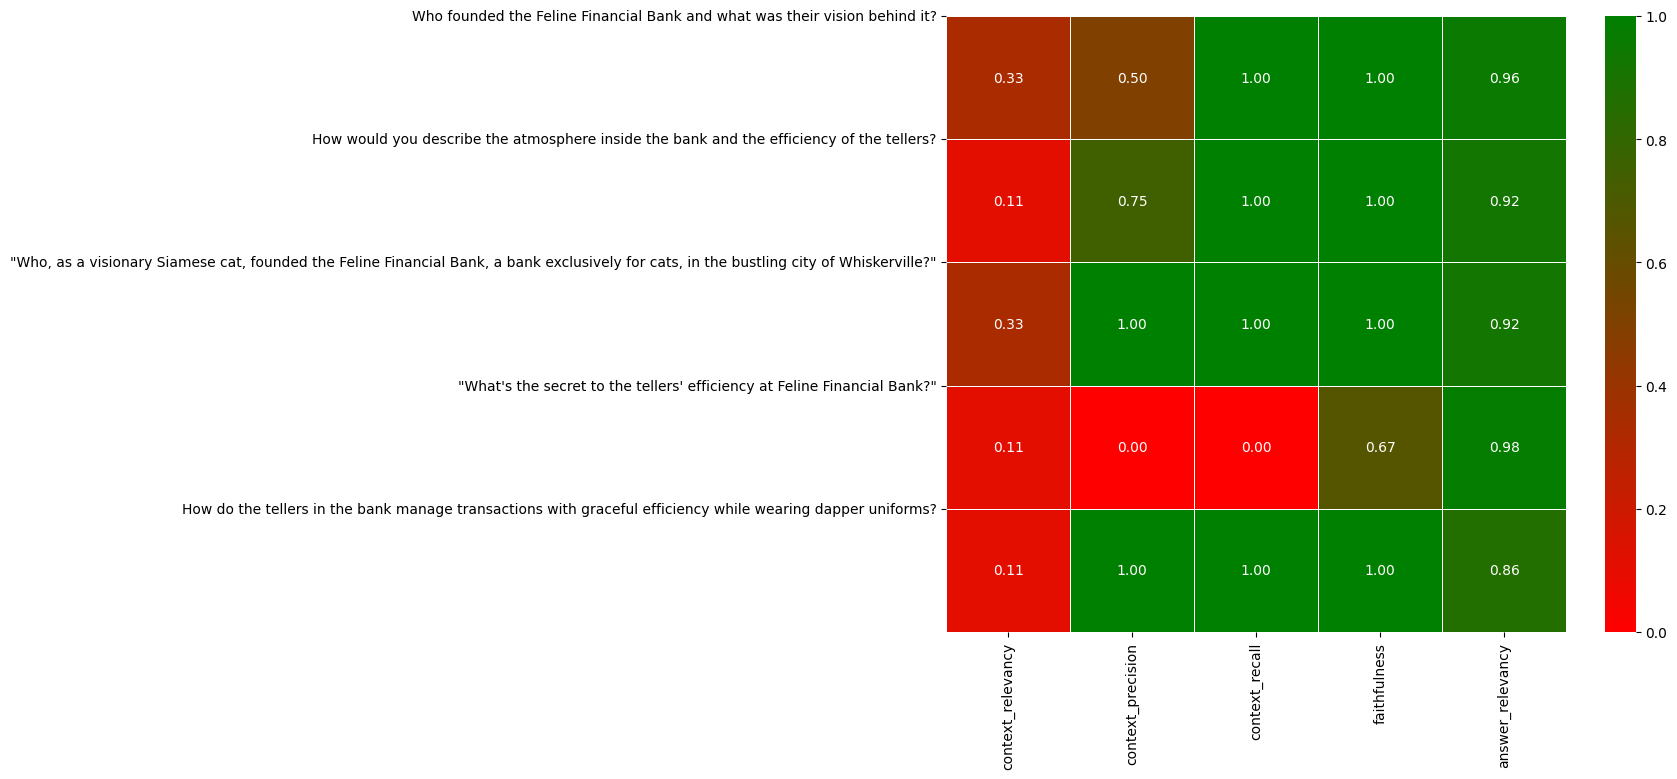

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['context_relevancy', 'context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()


### Add LangFuse

In [13]:
from langfuse import Langfuse

langfuse = Langfuse(
  secret_key="sk-lf-8be80c67-4187-4e43-9d01-544195dc9f03",
  public_key="pk-lf-d7653f64-8086-4365-b05c-865ead3478a3",
  host="http://localhost:3000"
)

In [14]:
trace = langfuse.trace(
    name = "eval",
    user_id = "eval_user",
    metadata = {
        "email": "prod@company.com",
    },
    tags = ["evaluation"]
)

In [15]:
df = result.to_pandas()

In [16]:
for _, row in df.iterrows():
    for metric_name in ["faithfulness", "answer_relevancy", "context_recall"]:
        langfuse.score(
            name=metric_name,
            value=row[metric_name],
            trace_id=trace.id
        )